In [30]:
import datetime, warnings, scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from scipy import stats as st

#import pandas
from keras.models import Sequential
from keras.layers import Dense # fully connected layers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedKFold
from sklearn.preprocessing import StandardScaler
import datetime
from datetime import date
from datetime import datetime
import winsound

### Loading Datasets

In [31]:
flights_train = pd.read_pickle('flights_train.pickle')
flights_test = pd.read_pickle('flights_test.pickle')

In [32]:
def drop_cols(df, cols):
    df = df.drop(cols, axis=1)
    return df

In [33]:
# Drop the unnecessary cols
cols = ['SCHEDULED_ARRIVAL', 'YEAR', 'DAY', 'TAIL_NUMBER', 'DEPARTURE_TIME1', 'SCHEDULED_DEPARTURE1']

train_set = drop_cols(flights_train, cols)
test_set = drop_cols(flights_test, cols)

display(train_set.head(1), train_set.shape)
display(test_set.head(1), test_set.shape)

,MONTH,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,ARRIVAL_DELAY,DEPARTURE_DELAY
id,,,,,,,,,,,,,,
0,1,4,AS,98,ANC,SEA,5,2354.0,21.0,15.0,205.0,1448,-22.0,-11.0


(2818553, 14)

,MONTH,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,DEPARTURE_DELAY
id,,,,,,,,,,,,,
0,7,3,NK,298,LAS,IAH,3,41.0,11.0,52.0,177.0,1222,38.0


(514384, 13)

We keep columns:
* Month
* Day of week
* Airline
* Origin airport
* Destination airport
* Scheduled time
* Distance
* Departure delay

### Encoding

Category columns:
* Airline
* Origin airport
* Destination airport
* Day of week
* Month

We will try applying TARGET Encoding to non-numeric columns:
* Airline
* Origin airport
* Destination airport

In [34]:
def target_encoding(df, target_encode_columns: list, target: list):
    target_encode_df = df[target_encode_columns + target].reset_index().drop(columns = 'id', axis = 1)
    target_name = target[0]
    target_df = pd.DataFrame()
    encoding_vals = {}
    for embed_col in target_encode_columns:
        val_map = target_encode_df.groupby(embed_col)[target].mean().to_dict()[target_name]
        target_df[embed_col] = target_encode_df[embed_col].map(val_map).values
        encoding_vals[embed_col] = val_map
    score_target_drop = df.drop(target_encode_columns, axis = 1).reset_index().drop(columns = 'id', axis = 1)
    score_target = pd.concat([score_target_drop, target_df], axis = 1)
    
    return score_target, encoding_vals

In [35]:
def test_encoding(df, encoding_vals):
    target_encode_columns = [col for col in encoding_vals.keys()]
    target_encode_df = df[target_encode_columns].reset_index().drop(columns = 'id', axis = 1)
    target_df = pd.DataFrame()
    for embed_col in encoding_vals.keys():
        val_map = encoding_vals[embed_col]
        target_df[embed_col] = target_encode_df[embed_col].map(val_map).values
    score_target_drop = df.drop(target_encode_columns, axis = 1).reset_index().drop(columns = 'id', axis = 1)
    score_target = pd.concat([score_target_drop, target_df], axis = 1)
    return score_target

In [36]:
target_encode_columns = ['FLIGHT_NUMBER', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DAY_OF_WEEK', 'MONTH']
target = ['ARRIVAL_DELAY']
train, encoding_vals = target_encoding(train_set, target_encode_columns, target)

X_train =train.drop(columns=['ARRIVAL_DELAY'])
Y_train = train['ARRIVAL_DELAY']

X_test = test_encoding(test_set, encoding_vals)

display(X_train.shape, X_train.dtypes)
display(X_test.shape, X_test.dtypes)

(2818553, 13)

SCHEDULED_DEPARTURE      int64
DEPARTURE_TIME         float64
TAXI_OUT               float64
WHEELS_OFF             float64
SCHEDULED_TIME         float64
DISTANCE                 int64
DEPARTURE_DELAY        float64
FLIGHT_NUMBER          float64
AIRLINE                float64
ORIGIN_AIRPORT         float64
DESTINATION_AIRPORT    float64
DAY_OF_WEEK            float64
MONTH                  float64
dtype: object

(514384, 13)

SCHEDULED_DEPARTURE      int64
DEPARTURE_TIME         float64
TAXI_OUT               float64
WHEELS_OFF             float64
SCHEDULED_TIME         float64
DISTANCE                 int64
DEPARTURE_DELAY        float64
FLIGHT_NUMBER          float64
AIRLINE                float64
ORIGIN_AIRPORT         float64
DESTINATION_AIRPORT    float64
DAY_OF_WEEK            float64
MONTH                  float64
dtype: object

### LGBM

Parameters have been found with GridSearch & some manual tuning

In [37]:
import lightgbm as lgb

In [38]:
d_train = lgb.Dataset(X_train, label=Y_train)

params_lgbm = {
    'task': 'predict',
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'n_jobs': 4,
    'num_iterations': 7500,
    'learning_rate': 0.01,
    'num_leaves': 128,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'feature_fraction': 0.5,
    'bagging_seed': 42,
    'verbosity': 1,
    'random_state': 42,
    'force_col_wise': True
}

Y_train = Y_train.ravel()
model_lgb = lgb.train(params_lgbm, d_train)
# RSE: 77.79266

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Info] Total Bins 2345
[LightGBM] [Info] Number of data points in the train set: 2818553, number of used features: 13
[LightGBM] [Info] Start training from score 6.001171


In [10]:
model_lgb.eval_train(predictions, train)

NameError: name 'model_lgb' is not defined

In [40]:
# Save the model
model_lgb.save_model('model_lgbm2.txt')
model_lgb.save_model("model_lgbm2.json")

In [46]:
# Load from model
model_lgb = lgb.Booster(model_file='model_lgbm_good.txt')

In [41]:
predictions = model_lgb.predict(X_test)

### Evaluate the model

In [15]:
import shap

In [19]:
expl = shap.TreeExplainer(model_lgb)

In [26]:
shap_values = expl.shap_values(X_train.iloc[:10000,:])

KeyError: 'objective'

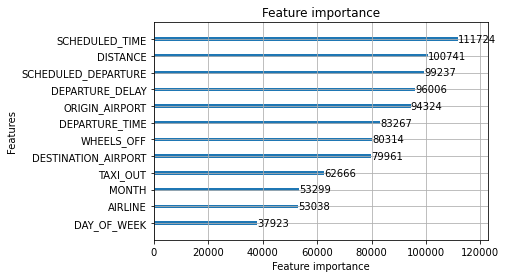

<Figure size 1152x864 with 0 Axes>

In [47]:
lgb.plot_importance(model_lgb)
# pd.DataFrame(predictions).to_csv("SUBMISSIONS/submission_lgb.csv")
plt.figure(figsize = (16, 12))
plt.show()
# plt.save('pics/FeatureImportanceLGBM.png')

In [42]:
winsound.Beep(440, 1000)

### Kaggle Submission Format

In [44]:
pd.DataFrame(predictions).to_csv("SUBMISSIONS/submission_lgb3.csv")

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

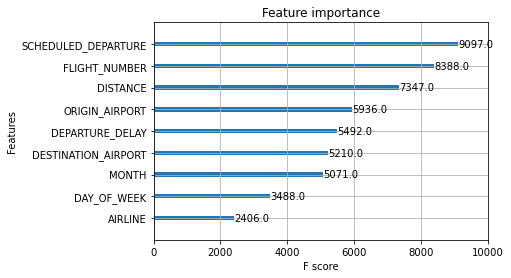

In [18]:
xgb.plot_importance(model_xgb_best)

In [208]:
X_train

,DAY_OF_WEEK,DEPARTURE_TIME,TAXI_OUT,SCHEDULED_TIME,DISTANCE,DEPARTURE_DELAY,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,MONTH
0,4,2354.0,21.0,205.0,1448,-11.0,-1.104695,-0.774214,1.326610,1
1,4,41.0,17.0,204.0,1448,-4.0,-1.104695,-0.774214,1.326610,1
2,4,31.0,25.0,210.0,1448,-14.0,1.694466,-0.774214,1.326610,1
3,4,46.0,11.0,215.0,1542,-4.0,-1.104695,-0.774214,1.966414,1
4,4,143.0,21.0,323.0,2552,-9.0,3.706209,-0.774214,3.088939,1
...,...,...,...,...,...,...,...,...,...,...
2818548,4,1315.0,9.0,72.0,196,6.0,6.968689,18.833333,9.525048,6
2818549,5,1315.0,5.0,72.0,196,6.0,6.968689,18.833333,9.525048,6
2818550,6,1308.0,16.0,72.0,196,-1.0,6.968689,18.833333,9.525048,6
2818551,1,1305.0,6.0,72.0,196,-4.0,6.968689,18.833333,9.525048,6


### Saving model

In [99]:
# save model and architecture to single file
# model_xgb_best.save("model_9.h5")
# save to JSON
model_xgb.save_model("model_xgb.json")
# save to text format
model_xgb.save_model("model_xgb.txt")
print("Saved model to disk")

NotFittedError: need to call fit or load_model beforehand

In [27]:
new_predictions = loaded_model.predict(X_test)
print(new_predictions)

[[ 40.38021  ]
 [-10.870261 ]
 [ -9.2564535]
 ...
 [ -3.8454266]
 [  5.260379 ]
 [ -0.757607 ]]


#### Save file for Kaggle submition

In [28]:
pd.DataFrame(new_predictions).to_csv("submission_9.csv")


In [140]:
X_train

,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_TIME,TAXI_OUT,SCHEDULED_TIME,DISTANCE,DEPARTURE_DELAY,MONTH
0,4,AS,ANC,SEA,2354.0,21.0,205.0,1448,-11.0,1
1,4,AS,ANC,SEA,41.0,17.0,204.0,1448,-4.0,1
2,4,DL,ANC,SEA,31.0,25.0,210.0,1448,-14.0,1
3,4,AS,ANC,PDX,46.0,11.0,215.0,1542,-4.0,1
4,4,US,ANC,PHX,143.0,21.0,323.0,2552,-9.0,1
...,...,...,...,...,...,...,...,...,...,...
2818548,4,B6,HYA,JFK,1315.0,9.0,72.0,196,6.0,6
2818549,5,B6,HYA,JFK,1315.0,5.0,72.0,196,6.0,6
2818550,6,B6,HYA,JFK,1308.0,16.0,72.0,196,-1.0,6
2818551,1,B6,HYA,JFK,1305.0,6.0,72.0,196,-4.0,6
